In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas
import math
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib import rnn

from create_train_test_val_maps import *

In [2]:

# get global index from (row, col) index
def sub2ind(array_shape, row, col):
    ind = row*array_shape[1] + col
    if row < 0 or row >= array_shape[0]:
        ind = -1
    if col < 0 or col >= array_shape[1]:
        ind = -1
    return ind

# get (row, col) index from global index
def ind2sub(array_shape, ind):
    row = int(ind) / array_shape[1]
    col = ind % array_shape[1]
    if ind < 0:
        row = -1
        col = -1
    if ind >=  array_shape[0]*array_shape[1]:
        row = -1
        col = -1
    return (row, col)

def one_hot_labels(labels, num_classes):
    one_hot_labels = np.zeros((labels.size, num_classes))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

In [3]:
num_windows = 5
window_size = 20
selected_codes = [0, 45021, 44004, 43004, 45008, 45002, 45007]

train_combined, val_combined, test_combined = load_maps(num_windows, window_size)

In [4]:
def get_data(selected_codes, data_map, num_windows):
    X = []
    Y = []
    for vehicleID in data_map.keys():
        for ATA6code in data_map[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            for window in data_map[vehicleID][ATA6code].keys():
                for sequence in data_map[vehicleID][ATA6code][window]:
                    Y.append(sub2ind((len(selected_codes),num_windows),selected_codes.index(ATA6code), window))
                    X.append(sequence.as_matrix()) 
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [5]:
num_codes = len(selected_codes)

# Get data
train_fieldsnaps,train_results = get_data(selected_codes, train_combined, num_windows)
validation_fieldsnaps,validation_results = get_data(selected_codes, val_combined, num_windows)
test_fieldsnaps,test_results = get_data(selected_codes, test_combined, num_windows)

# Turn into One Hot Labels
one_hot_train_results = one_hot_labels(train_results, num_codes*num_windows)
one_hot_validation_results = one_hot_labels(validation_results, num_codes*num_windows)
one_hot_test_results = one_hot_labels(test_results, num_codes*num_windows)

print('shape: (number of samples) x (number of time steps) x (number of features)')
print("train_fieldsnaps shape: ", train_fieldsnaps.shape)
print("validation_fieldsnaps shape: ", validation_fieldsnaps.shape)
print("test_fieldsnaps shape: ", test_fieldsnaps.shape)

print("train_results.shape: ", train_results.shape)
print("validation_results.shape: ", validation_results.shape)
print("test_results.shape: ", test_results.shape)

print("one_hot_train_results.shape: ", one_hot_train_results.shape)
print("one_hot_validation_results.shape: ", one_hot_validation_results.shape)
print("one_hot_test_results.shape: ", one_hot_test_results.shape)


shape: (number of samples) x (number of time steps) x (number of features)
train_fieldsnaps shape:  (946, 20, 61)
validation_fieldsnaps shape:  (197, 20, 61)
test_fieldsnaps shape:  (137, 20, 61)
train_results.shape:  (946,)
validation_results.shape:  (197,)
test_results.shape:  (137,)
one_hot_train_results.shape:  (946, 35)
one_hot_validation_results.shape:  (197, 35)
one_hot_test_results.shape:  (137, 35)


In [6]:
#print(np.count_nonzero(train_results))
print('number of validation samples: ', len(validation_results))
print('number of non repairs in validation set: ',len(validation_results) - np.count_nonzero(validation_results))
print('percent of non repairs in validation set: ',(len(validation_results) - np.count_nonzero(validation_results))/len(validation_results))
#print(np.count_nonzero(test_results))
print('number of test samples: ',len(test_results))
print('number of non repairs in test set: ',len(test_results) - np.count_nonzero(test_results))
print('percent of non repairs in test set: ',(len(test_results) - np.count_nonzero(test_results))/len(test_results))

number of validation samples:  197
number of non repairs in validation set:  93
percent of non repairs in validation set:  0.4720812182741117
number of test samples:  137
number of non repairs in test set:  69
percent of non repairs in test set:  0.5036496350364964


In [7]:
def RNN(x, weights, biases, num_hidden, timesteps):
    

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [8]:
def train_RNN(save_file, 
              learning_rate,
              lambda_,
              num_hidden,
              num_clases,
              num_epochs, 
              iters_per_epoch, 
              batch_size, 
              timesteps, 
              num_input, 
              window_size, 
              num_windows,
              num_codes,
              train_X, 
              train_Y, 
              val_X, 
              val_Y):    
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # Set up Graph
    tf.reset_default_graph()
    #------------------------- 
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes]) # num_classes

    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_classes]))
    }

    logits = RNN(X, weights, biases, num_hidden, timesteps)
    prediction = tf.nn.softmax(logits)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y)) 
    regularizer = tf.nn.l2_loss(weights['out'])
    loss_op = tf.reduce_mean(loss_op + lambda_*regularizer)


    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model (with test logits, for dropout to be disabled)
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # TRAIN ----------------------------------
    saver = tf.train.Saver()
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        # Start training
        for epoch in range(0,num_epochs):
            for iter_ in range(0, iters_per_epoch):
                #print(iter_)
                if (iter_ + batch_size) > train_fieldsnaps.shape[0]:
                    continue
                batch_x = train_fieldsnaps[iter_:iter_ + batch_size]
                #print("batch_x.shape: ", batch_x.shape)
                batch_y = one_hot_train_results[iter_:iter_ + batch_size]
                #print("batch_y.shape: ", batch_y.shape)
                # Reshape data to get 28 seq of 28 elements
                batch_x = batch_x.reshape((batch_size, timesteps, num_input))
                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})


            train_loss, train_acc = sess.run([loss_op, accuracy], feed_dict={X: train_X,
                                                                 Y: train_Y})
            val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: val_X,
                                                                 Y: val_Y})
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)


            print("\nEpoch " + str(epoch) + '\n-------------------\n' + "Training Loss= " + \
                  "{:.4f}".format(train_loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(train_acc) + '\n' + "Validation Loss= " + \
                 "{:.4f}".format(val_loss) + ", Validation Accuracy= " + \
                  "{:.3f}".format(val_acc))

        print("\nOptimization Finished!")
        saver.save(sess, save_file)
        return train_losses, train_accs, val_losses, val_accs
    
    
def test_rnn(save_file,
             learning_rate,
             lambda_,
             num_hidden,
             num_classes,
             batch_size, 
              timesteps, 
              num_input, 
              window_size, 
              num_windows, 
              num_codes,
              test_X, 
              test_Y):
        
    # Set Up The Same Graph
    #-------------------------
    # Training Parameters
    tf.reset_default_graph()

    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes]) # num_classes

    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_classes]))
    }

    logits = RNN(X, weights, biases, num_hidden, timesteps)
    prediction = tf.nn.softmax(logits)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y)) 
    regularizer = tf.nn.l2_loss(weights['out'])
    loss_op = tf.reduce_mean(loss_op + lambda_*regularizer)


    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model (with test logits, for dropout to be disabled)
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    saver = tf.train.Saver() 

    with tf.Session() as sess:
        saver.restore(sess, './' + save_file)
        # Calculate accuracy
        #test_accuracy = sess.run(accuracy, feed_dict={X: test_X, Y: test_Y})
        test_accuracy = sess.run(accuracy, feed_dict={X: test_X, Y: test_Y})

    return test_accuracy


def plot_results(num_epochs, train_losses, train_accs, val_losses, val_accs):
    plot_training_accuracy = plt.plot(np.arange(0,num_epochs),train_accs ,label='Training')
    plot_val_accuracy = plt.plot(np.arange(0,num_epochs),val_accs,label='Validation')
    ax = plt.gca() # grab the current axis
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.suptitle("")
    plt.title('Training vs Validation Accuracy')
    mylegend = plt.legend(loc="right corner",bbox_to_anchor=(1,1))
    plt.rcParams["figure.figsize"] = [6,5]
    plt.savefig('Training vs Validation Accuracy'.replace(" ", "_"), bbox_extra_artists=(mylegend,), bbox_inches="tight")
    plt.show()



    plot_training_accuracy = plt.plot(np.arange(0,num_epochs),train_losses ,label='Training')
    plot_val_accuracy = plt.plot(np.arange(0,num_epochs),val_losses,label='Validation')
    ax = plt.gca() # grab the current axis
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.suptitle("")
    plt.title('Training vs Validation Loss')
    mylegend = plt.legend(loc="right corner")
    plt.savefig('Training vs Validation Accuracy'.replace(" ", "_"))
    plt.show()


Epoch 0
-------------------
Training Loss= 28.3799, Training Accuracy= 0.525
Validation Loss= 29.1166, Validation Accuracy= 0.437

Epoch 1
-------------------
Training Loss= 27.5932, Training Accuracy= 0.507
Validation Loss= 28.4294, Validation Accuracy= 0.401

Epoch 2
-------------------
Training Loss= 27.4067, Training Accuracy= 0.473
Validation Loss= 28.3261, Validation Accuracy= 0.345

Epoch 3
-------------------
Training Loss= 27.4523, Training Accuracy= 0.526
Validation Loss= 28.3540, Validation Accuracy= 0.431

Epoch 4
-------------------
Training Loss= 27.3694, Training Accuracy= 0.516
Validation Loss= 28.2434, Validation Accuracy= 0.391

Epoch 5
-------------------
Training Loss= 27.2869, Training Accuracy= 0.518
Validation Loss= 28.2109, Validation Accuracy= 0.371

Epoch 6
-------------------
Training Loss= 27.2567, Training Accuracy= 0.526
Validation Loss= 28.0611, Validation Accuracy= 0.437

Epoch 7
-------------------
Training Loss= 27.2452, Training Accuracy= 0.529
Valid

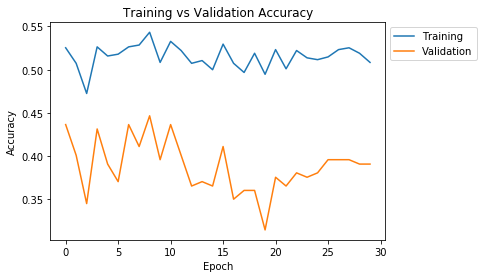

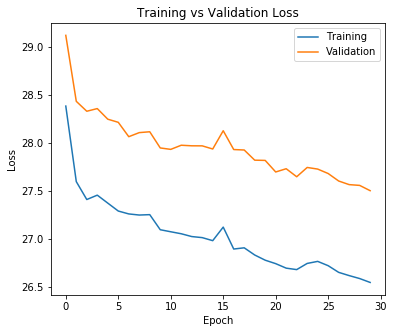

In [9]:
num_epochs = 30
i = 1
save_file = 'train_model'  + str(i) + '.ckpt'


batch_size = 11 
iters_per_epoch = 86


num_input = 61
timesteps = window_size


learning_rate = 0.001 # alpha
lambda_ = 0.01

# Network Parameters
num_hidden = 139 # hidden layer num of features
num_classes = num_codes*num_windows # 

train_losses, train_accs, val_losses, val_accs = train_RNN(save_file, 
                                                           learning_rate,
                                                           lambda_,
                                                           num_hidden,
                                                           num_classes,
                                                           num_epochs, 
                                                           iters_per_epoch, 
                                                           batch_size, 
                                                           timesteps, 
                                                           num_input, 
                                                           window_size,
                                                           num_windows,
                                                           num_codes,
                                                           train_fieldsnaps, 
                                                           one_hot_train_results, 
                                                           validation_fieldsnaps, 
                                                           one_hot_validation_results)


accuracy = test_rnn(save_file,
              learning_rate,
              lambda_,
              num_hidden,
              num_classes,
              batch_size, 
              timesteps, 
              num_input, 
              window_size, 
              num_windows, 
              num_codes,
              test_fieldsnaps, 
              one_hot_test_results)

print('\nAccuracy', accuracy)

plot_results(num_epochs, train_losses, train_accs, val_losses, val_accs)

In [ ]:
# (10,10), batch_size = 28, num_iter = 68
# (5,20),  batch_size = 11, num_iter = 86
# (5,50),  batch_size = 29, num_iter = 29
# (5,100), batch_size = 15, num_iter = 47
# (1,50),  batch_size = , num_iter = 
859/14

In [ ]:
for i in range(1,192):
    if 192%i == 0:
        print(i)

In [ ]:
192/12